# Aluno: Rodrigo

In [1]:
# Imports
import haversine as hs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
pd.options.display.float_format = '{:.6f}'.format

In [2]:
# Parâmetros gerais do algoritmo
alfa = 1                                          # parametro de influência do feromônio
beta = 1                                          # parametro de influência da distância
coeficiente_evaporacao = 0.05
feromonio_inicial = 0.1
constante_atualizacao_feromonio = 1

# Controle de iterações
quantidade_iteracoes = 1000 # a outra condição de para é a estagnação

In [3]:
# Leitura dos dados das cidades
df = pd.read_csv('dados/campis_ifpi6.csv', header=0, delimiter=";")
df

,Cidade,Latitude,Longitude
0,Corrente,-10.436519,-45.192141
1,Teresina,-5.093382,-42.881167
2,Parnaíba,-2.930402,-41.765683
3,Picos,-7.072445,-41.507629
4,Uruçuí,-7.241070,-44.562747


In [4]:
# Cria um dicionário com as chaves e valores de cada cidade
dicionario = {}
for i in range(len(df)):
    dicionario[i] = df.iloc[i,0]

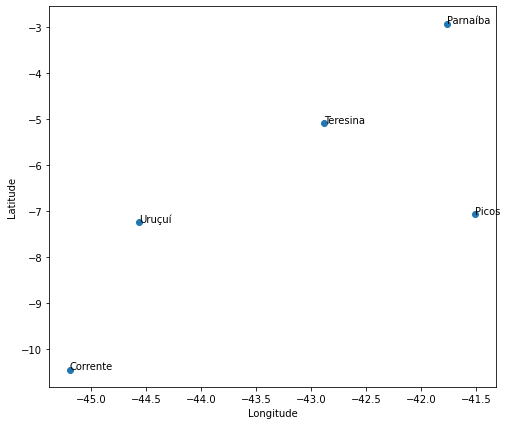

In [5]:
# Plot gráfico
lat = df['Latitude']
lon = df['Longitude']
cid = df['Cidade']

plt.figure(figsize = (8,7))
plt.scatter(lon, lat)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

for i, txt in enumerate(cid):
    plt.annotate(txt, (lon[i], lat[i]))
plt.show()

## Funções utilizadas no decorrer da ACO

In [6]:
# Calcula distancia entre cidades
def calcula_distancia(cidade1, cidade2):
    cid1 = (df.iloc[cidade1, 1], df.iloc[cidade1, 2])
    cid2 = (df.iloc[cidade2, 1], df.iloc[cidade2, 2])
    
    return hs.haversine(cid1, cid2)

In [7]:
# Cria as arestas entre todas as cidades
def cria_arestas_iniciais():
    
    origem, destino, distancias = [], [], []
    
    # Itera em cada uma das cidades
    for i in range(len(df)): #[0, 1, 2, 3, 4]
        for j in range(len(df)): #[0, 1, 2, 3, 4]
            if (i != j):
                distancia = calcula_distancia(i, j)
                
                origem.append(i)
                destino.append(j)
                distancias.append(distancia)
        
    return origem, destino, distancias

In [8]:
origem, destino, distancias = cria_arestas_iniciais()

In [9]:
# Exemplificação
distancias = [22, 50, 48, 29, 22, 30, 34, 32, 50, 30, 22, 23, 48, 34, 22, 35, 29, 32, 23, 35]

In [10]:
# Soma todas as rotas para cada cidade
def somatorio_rotas(iteracoes):
    
    for j in range(len(df)): # para cada cidade [0, 1, 2, 3, 4]
        indices = [i for i in range(len(origem)) if j == origem[i]] # indices das rotas
        
        # soma as distancias de todas as rotas para cada cidade
        # somatorio(feromonio * 1/distancia)
        iteracoes.iloc[indices,6] = sum(np.power(iteracoes.iloc[indices,4], alfa) * np.power(iteracoes.iloc[indices,3], beta))
        
        '''
        print("Feromônio: ", iteracoes.iloc[indices,4])
        print("1/distancia: ", iteracoes.iloc[indices,3])
        print("Soma da rota da cidade %s: %s" % (j, iteracoes.iloc[indices,6]))
        '''
        
    return iteracoes

In [11]:
# Retornar os indices pra cidade cidade 0
[i for i in range(len(origem)) if 0 == origem[i]]

[0, 1, 2, 3]

In [12]:
origem

[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]

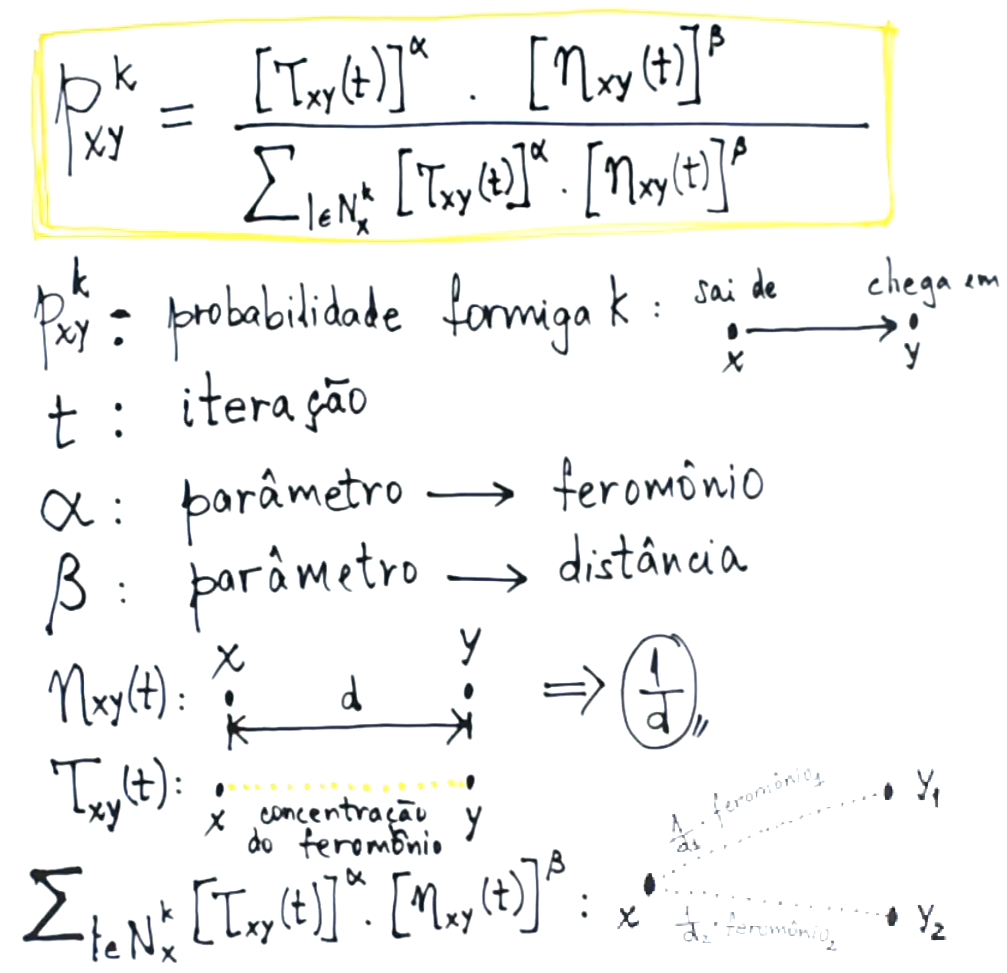

In [13]:
# Probabilidade de escolha de rota
Image(filename = "dados/probabilidade.png", width=700)

In [14]:
# Tabela de probabilidade inicial
def tabela_probabilidade_inicial():
    
    # Montando tabela
    iteracoes = pd.DataFrame()
    
    iteracoes['Origem'] = origem
    iteracoes['Destino'] = destino
    iteracoes['Distancia'] = distancias
    iteracoes['1/distancia'] = [1/i for i in distancias]
    
    # Feromônio inicial
    iteracoes['Feromonio'] = feromonio_inicial
    iteracoes['F * 1/D'] = np.power(iteracoes['Feromonio'], alfa) * np.power(iteracoes['1/distancia'], beta)
    
    # Somatório de rotas
    iteracoes['Soma_rotas'] = 0
    iteracoes = somatorio_rotas(iteracoes)
    
    # Calculo de probabilidade 
    iteracoes['Probabilidade'] = iteracoes['F * 1/D'] / iteracoes['Soma_rotas']
    iteracoes['Probabilidade(%)'] = iteracoes['Probabilidade'] * 100
    
    return iteracoes

In [15]:
# Seleção de rotas com base na probabilidade
def selecao_primeira_rota(cidade_atual, iteracao_atual):
    
    # Remove a cidade atual das proximas iterações
    iteracao_atual = iteracao_atual[iteracao_atual.Destino != cidade_atual] 
    inicio = list(iteracao_atual.Origem)

    indices = [i for i in range(len(inicio)) if cidade_atual == inicio[i]]

    destinos = list(iteracao_atual.iloc[indices, 1])
    probalilidades = list(iteracao_atual.iloc[indices, 7])
    
    # Não é necessário fazer o ajuste de probabilidades para traçar a 1ª rota
    rota_selecionada = np.random.choice(destinos, p=probalilidades)

    # Calcula distância total percorrida
    distancia_rota = list(
        iteracao_atual.Distancia[
            (iteracao_atual.Origem == cidade_atual) & (iteracao_atual.Destino == rota_selecionada)
        ])[0]

    
    print("Cidade: ", cidade_atual)
    print("Destinos: ", destinos)
    print("Probabilidades: ", probalilidades)
    print("Rota selecionada: ", rota_selecionada)
    print("Distância percorrida: ", distancia_rota)
    
    
    return rota_selecionada, distancia_rota, iteracao_atual

In [16]:
# Seleção de rotas com base na probabilidade
def selecao_outras_rotas(cidade_atual, iteracao_atual):

    # Remove a cidade atual das proximas iterações
    iteracao_atual = iteracao_atual[iteracao_atual.Destino != cidade_atual]
    inicio = list(iteracao_atual.Origem)

    indices = [i for i in range(len(inicio)) if cidade_atual == inicio[i]]

    destinos = list(iteracao_atual.iloc[indices, 1])
    probalilidades = list(iteracao_atual.iloc[indices, 7])   

    # Ajuste de probabilidades
    
    '''
    1 -- 0  = 30%  ---> excluir
    1 -- 2  = 40%   ---> 40/70  ---> 57% 
    1 -- 3  = 10%   ---> 10/70  ---> 14%
    1 -- 4  = 20%   ---> 20/70  ---> 28% 
    '''
    
    # 1  ---> [2, 3, 4]
    soma_probabilidades = sum(probalilidades)
    probalilidades = [i/soma_probabilidades for i in probalilidades]
    rota_selecionada = np.random.choice(destinos, p=probalilidades)

    # Calcula distância total percorrida
    distancia_rota = list(
        iteracao_atual.Distancia[
            (iteracao_atual.Origem == cidade_atual) & (iteracao_atual.Destino == rota_selecionada)
        ])[0]

    
    print("-------------------")
    print("Cidade: ", cidade_atual)
    print("Destinos: ", destinos)
    print("Probabilidades: ", probalilidades)
    print("Rota selecionada: ", rota_selecionada)
    print("Distância percorrida: ", distancia_rota)
    
    
    return rota_selecionada, distancia_rota, iteracao_atual

In [17]:
# Seleção da rota para a ultima cidade
def selecao_ultima_rota(cidade_atual, cidade_partida):

    # Calcula distância total percorrida
    distancia_rota = list(
        iteracoes.Distancia[
            (iteracoes.Origem == cidade_atual) & (iteracoes.Destino == cidade_partida)
        ])[0]

    
    print("-------------------")
    print("Cidade: ", cidade_atual)
    print("Rota selecionada: ", cidade_partida)
    print("Distância percorrida: ", distancia_rota)
    
    
    return distancia_rota

In [18]:
# Seleção de rotas
def selecao_rotas():
    
    # Cria a tabela de rotas e distâncias para cada formiga
    rotas_distancias = pd.DataFrame(columns=['Formiga', 'Rota', 'Distancia'])
    
    quantidade_demais_rotas = len(df) - 2

    # Quantidae de formigas = quantidade de rotas
    for i in range(len(df)): # [0, 1, 2, 3, 4]

        distancia_total = 0
        rota = str(i) + "-"

        # Primeira rota
        rota_selecionada, distancia_rota, iteracao_atual = selecao_primeira_rota(i, iteracoes)
        distancia_total += distancia_rota
        rota += str(rota_selecionada) + "-"

        # Demais rotas
        for j in range(quantidade_demais_rotas):
            rota_selecionada, distancia_rota, iteracao_atual = selecao_outras_rotas(rota_selecionada, iteracao_atual)
            distancia_total += distancia_rota
            rota += str(rota_selecionada) + "-"

        # Ultima rota
        distancia_rota = selecao_ultima_rota(rota_selecionada, i)
        distancia_total += distancia_rota
        rota += str(i)

        
        print("Formiga %s partindo da cidade %s\n" %(i+1, i))
        print("---------------------------")
        print("Distância total da rota: ", distancia_total)
        print("Rota percorrida: ", rota)

        print("---------------------------------------------------------\n")
        

        # Insere no dataframe os resultados de cada formiga
        nova_linha = {'Formiga':i, 'Rota':rota, 'Distancia':distancia_total}
        rotas_distancias = rotas_distancias.append(nova_linha, ignore_index=True)
        
    return rotas_distancias

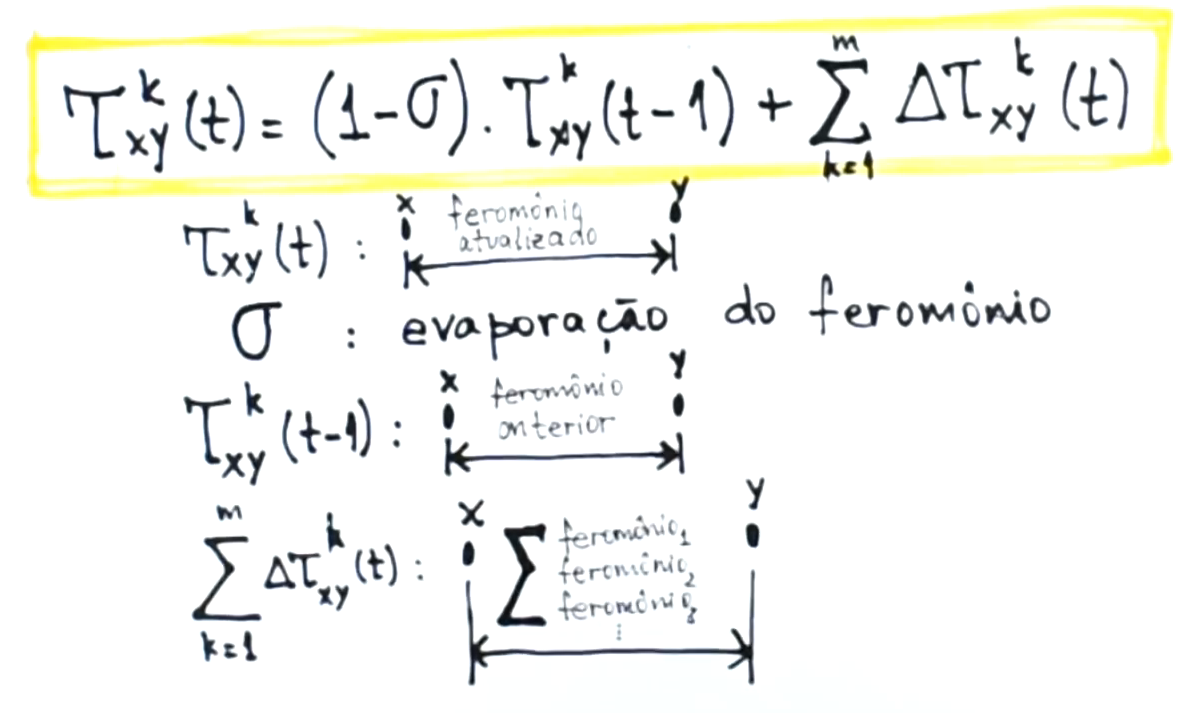

In [19]:
# Atualização do feromônio após cada iteração
Image(filename = "dados/atualizacao_feromonio_apos_cada_iteracao.png", width=800)

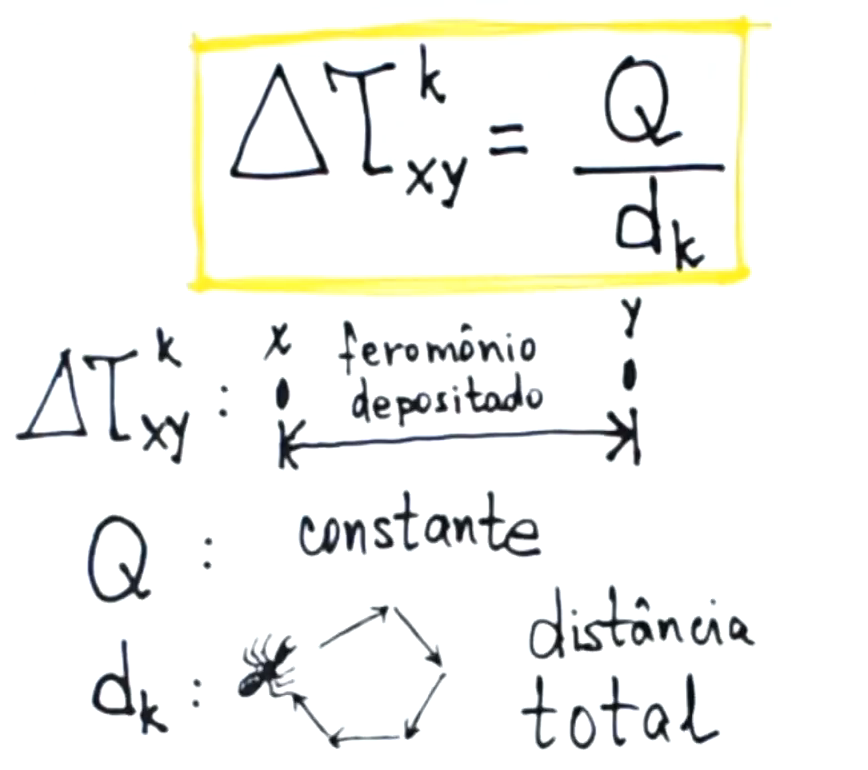

In [20]:
# Feromônio depositado em cada rota
Image(filename = "dados/feromonio_depositado_em_cada_rota.png", width=500)

In [21]:
# Atualização de feromônio
def atualiza_feromonio(atualizacao_feromonio, rotas_distancias):

    # Feromonio após evaporação
    atualizacao_feromonio['FIAV'] = (1 - coeficiente_evaporacao) * iteracoes['Feromonio']

    # Atribui 0 as colunas de feromonio para cada formiga
    for i in range(len(df)): # [0, 1, 2, 3, 4]
        atualizacao_feromonio[str(i)] = 0

    # Atualização feromônio
    for i in range(len(atualizacao_feromonio)):
        inicio = str(atualizacao_feromonio.iloc[i,0])
        fim = str(atualizacao_feromonio.iloc[i,1])
        ida = inicio + "-" + fim     # 0-1
        volta = fim + "-" + inicio   # 1-0

        # Atualiza o feromonio de cada rota (ida ou volta)
        for j in range(len(rotas_distancias)):        
            if (ida in str(rotas_distancias.iloc[j,1])) or (volta in str(rotas_distancias.iloc[j,1])):
                atualizacao_feromonio.loc[i,str(j)] = constante_atualizacao_feromonio / rotas_distancias.iloc[j,2]

    # Total feromônio na rota (somatorio de todas as formigas e feromonio inicial após evaporação)
    atualizacao_feromonio['Total'] = atualizacao_feromonio.iloc[:,2:8].sum(axis=1)
    
    return atualizacao_feromonio

In [22]:
# Atualiza feromônio e probabilidade na tabela de iterações
def atualiza_probabilidade_iteracoes(iteracoes):
    
    iteracoes['Feromonio'] = atualizacao_feromonio['Total']
    iteracoes['F * 1/D'] = np.power(iteracoes['Feromonio'], alfa) * np.power(iteracoes['1/distancia'], beta)
    iteracoes = somatorio_rotas(iteracoes) # somatorio((feromonio[x] * 1/distancias[x])
    iteracoes['Probabilidade'] = iteracoes['F * 1/D'] / iteracoes['Soma_rotas']
    iteracoes['Probabilidade(%)'] = iteracoes['Probabilidade'] * 100
    
    return iteracoes

In [23]:
# Pega a rota com menor distância em todas as iterações
def rota_menor_custo(y, cont, rotas_distancias, menor_custo_geral, tabela_menor_custo):
    
    if y == 0: # na primeira iteração
        
        menor_custo_geral = rotas_distancias.Distancia.min()
        tabela_menor_custo = rotas_distancias.sort_values(by = ['Distancia']).head(1)

    elif rotas_distancias.Distancia.min() < menor_custo_geral:

        cont = y
        menor_custo_geral = rotas_distancias.Distancia.min()
        tabela_menor_custo = rotas_distancias.sort_values(by = ['Distancia']).head(1)
    
    return cont, menor_custo_geral, tabela_menor_custo

## Tabela de probabilidade

In [24]:
iteracoes = tabela_probabilidade_inicial()

In [25]:
iteracoes

,Origem,Destino,Distancia,1/distancia,Feromonio,F * 1/D,Soma_rotas,Probabilidade,Probabilidade(%)
0,0,1,22,0.045455,0.100000,0.004545,0.012077,0.376371,37.637083
1,0,2,50,0.020000,0.100000,0.002000,0.012077,0.165603,16.560317
2,0,3,48,0.020833,0.100000,0.002083,0.012077,0.172503,17.250330
3,0,4,29,0.034483,0.100000,0.003448,0.012077,0.285523,28.552270
4,1,0,22,0.045455,0.100000,0.004545,0.013945,0.325957,32.595670
5,1,2,30,0.033333,0.100000,0.003333,0.013945,0.239035,23.903491
6,1,3,34,0.029412,0.100000,0.002941,0.013945,0.210913,21.091316
7,1,4,32,0.031250,0.100000,0.003125,0.013945,0.224095,22.409523
8,2,0,50,0.020000,0.100000,0.002000,0.014227,0.140582,14.058159
9,2,1,30,0.033333,0.100000,0.003333,0.014227,0.234303,23.430265


In [26]:
dicionario

{0: 'Corrente', 1: 'Teresina', 2: 'Parnaíba', 3: 'Picos', 4: 'Uruçuí'}

## Iterações no algoritmo

In [27]:
# Atualização do feromônio (colunas Origem e Destino são fixas)
atualizacao_feromonio = pd.DataFrame()
atualizacao_feromonio['Origem'] = iteracoes['Origem']
atualizacao_feromonio['Destino'] = iteracoes['Destino']
atualizacao_feromonio['FIAV'] = iteracoes['Feromonio']

# Variáveis de controle
menor_custo_geral, cont = 0, 0
tabela_menor_custo = pd.DataFrame()

In [28]:
# Iterações no algoritmo
for y in range(quantidade_iteracoes):
    
    # Seleção de rotas
    rotas_distancias = selecao_rotas()
    
    # Best-so-far de menor distância em todas as iterações (mínimo global)
    cont, menor_custo_geral, tabela_menor_custo = rota_menor_custo(y, cont, rotas_distancias, menor_custo_geral, tabela_menor_custo)
    
    # Realização da atualização do feromônio
    atualizacao_feromonio = atualiza_feromonio(atualizacao_feromonio, rotas_distancias)
    
    # Atualiza tabela de probabilidade
    iteracoes = atualiza_probabilidade_iteracoes(iteracoes)
    
    # Critério de parada: estagnação
    if (int(rotas_distancias.Distancia.std()) == 0 and int(rotas_distancias.Distancia.min()) == int(menor_custo_geral)):
        print("Estagnação das rotas na %sª iteração" %(y + 1))
        break

Cidade:  0
Destinos:  [1, 2, 3, 4]
Probabilidades:  [0.37637083342346045, 0.16560316670632258, 0.17250329865241937, 0.28552270121779755]
Rota selecionada:  1
Distância percorrida:  22
-------------------
Cidade:  1
Destinos:  [2, 3, 4]
Probabilidades:  [0.3546284224250327, 0.31290743155149936, 0.3324641460234681]
Rota selecionada:  2
Distância percorrida:  30
-------------------
Cidade:  2
Destinos:  [3, 4]
Probabilidades:  [0.5111111111111111, 0.4888888888888889]
Rota selecionada:  3
Distância percorrida:  22
-------------------
Cidade:  3
Destinos:  [4]
Probabilidades:  [1.0]
Rota selecionada:  4
Distância percorrida:  35
-------------------
Cidade:  4
Rota selecionada:  0
Distância percorrida:  29
Formiga 1 partindo da cidade 0

---------------------------
Distância total da rota:  138
Rota percorrida:  0-1-2-3-4-0
---------------------------------------------------------

Cidade:  1
Destinos:  [0, 2, 3, 4]
Probabilidades:  [0.3259566988895103, 0.23903491251897419, 0.210913158104977

Cidade:  4
Destinos:  [0, 1, 2, 3]
Probabilidades:  [0.2649848723379125, 0.2236744188024696, 0.3150496758827505, 0.19629103297686737]
Rota selecionada:  2
Distância percorrida:  23
-------------------
Cidade:  2
Destinos:  [0, 1, 3]
Probabilidades:  [0.16987540824940864, 0.29163308043542074, 0.5384915113151706]
Rota selecionada:  1
Distância percorrida:  30
-------------------
Cidade:  1
Destinos:  [0, 3]
Probabilidades:  [0.6586637169842047, 0.3413362830157954]
Rota selecionada:  0
Distância percorrida:  22
-------------------
Cidade:  0
Destinos:  [3]
Probabilidades:  [1.0]
Rota selecionada:  3
Distância percorrida:  48
-------------------
Cidade:  3
Rota selecionada:  4
Distância percorrida:  35
Formiga 5 partindo da cidade 4

---------------------------
Distância total da rota:  158
Rota percorrida:  4-2-1-0-3-4
---------------------------------------------------------

Cidade:  0
Destinos:  [1, 2, 3, 4]
Probabilidades:  [0.4382935850936698, 0.1266189057836375, 0.1427418870793441, 

-------------------
Cidade:  2
Destinos:  [0, 1, 4]
Probabilidades:  [0.15093001636640285, 0.3432211794078933, 0.5058488042257038]
Rota selecionada:  0
Distância percorrida:  50
-------------------
Cidade:  0
Destinos:  [1, 4]
Probabilidades:  [0.6272995058574622, 0.37270049414253775]
Rota selecionada:  4
Distância percorrida:  29
-------------------
Cidade:  4
Destinos:  [1]
Probabilidades:  [1.0]
Rota selecionada:  1
Distância percorrida:  32
-------------------
Cidade:  1
Rota selecionada:  3
Distância percorrida:  34
Formiga 4 partindo da cidade 3

---------------------------
Distância total da rota:  167
Rota percorrida:  3-2-0-4-1-3
---------------------------------------------------------

Cidade:  4
Destinos:  [0, 1, 2, 3]
Probabilidades:  [0.2551877001422559, 0.19138073342087758, 0.345705465434468, 0.2077261010023985]
Rota selecionada:  1
Distância percorrida:  32
-------------------
Cidade:  1
Destinos:  [0, 2, 3]
Probabilidades:  [0.5085724150669594, 0.27773952143081887, 0.2

Cidade:  3
Destinos:  [0, 1, 2, 4]
Probabilidades:  [0.14253990981480244, 0.19209998833186703, 0.43072750708558155, 0.23463259476774892]
Rota selecionada:  2
Distância percorrida:  22
-------------------
Cidade:  2
Destinos:  [0, 1, 4]
Probabilidades:  [0.14369405725241718, 0.35228353831147646, 0.5040224044361064]
Rota selecionada:  0
Distância percorrida:  50
-------------------
Cidade:  0
Destinos:  [1, 4]
Probabilidades:  [0.6305954507240263, 0.3694045492759737]
Rota selecionada:  4
Distância percorrida:  29
-------------------
Cidade:  4
Destinos:  [1]
Probabilidades:  [1.0]
Rota selecionada:  1
Distância percorrida:  32
-------------------
Cidade:  1
Rota selecionada:  3
Distância percorrida:  34
Formiga 4 partindo da cidade 3

---------------------------
Distância total da rota:  167
Rota percorrida:  3-2-0-4-1-3
---------------------------------------------------------

Cidade:  4
Destinos:  [0, 1, 2, 3]
Probabilidades:  [0.26351704175345747, 0.17575558519511555, 0.3433975588027

-------------------
Cidade:  2
Destinos:  [0, 1, 4]
Probabilidades:  [0.12059404813242502, 0.34784913867382405, 0.5315568131937509]
Rota selecionada:  4
Distância percorrida:  23
-------------------
Cidade:  4
Destinos:  [0, 1]
Probabilidades:  [0.649306577077474, 0.35069342292252603]
Rota selecionada:  1
Distância percorrida:  32
-------------------
Cidade:  1
Destinos:  [0]
Probabilidades:  [1.0]
Rota selecionada:  0
Distância percorrida:  22
-------------------
Cidade:  0
Rota selecionada:  3
Distância percorrida:  48
Formiga 4 partindo da cidade 3

---------------------------
Distância total da rota:  147
Rota percorrida:  3-2-4-1-0-3
---------------------------------------------------------

Cidade:  4
Destinos:  [0, 1, 2, 3]
Probabilidades:  [0.2807061927327878, 0.15161068598457422, 0.35831277226346225, 0.20937034901917576]
Rota selecionada:  0
Distância percorrida:  29
-------------------
Cidade:  0
Destinos:  [1, 2, 3]
Probabilidades:  [0.7016876622597773, 0.11940312760046416, 

Cidade:  3
Destinos:  [0, 1, 2, 4]
Probabilidades:  [0.1235701041181396, 0.2091042143906611, 0.4700690927470653, 0.19725658874413396]
Rota selecionada:  2
Distância percorrida:  22
-------------------
Cidade:  2
Destinos:  [0, 1, 4]
Probabilidades:  [0.1311768641123516, 0.3100210906200075, 0.5588020452676409]
Rota selecionada:  4
Distância percorrida:  23
-------------------
Cidade:  4
Destinos:  [0, 1]
Probabilidades:  [0.6298659510976404, 0.3701340489023597]
Rota selecionada:  0
Distância percorrida:  29
-------------------
Cidade:  0
Destinos:  [1]
Probabilidades:  [1.0]
Rota selecionada:  1
Distância percorrida:  22
-------------------
Cidade:  1
Rota selecionada:  3
Distância percorrida:  34
Formiga 4 partindo da cidade 3

---------------------------
Distância total da rota:  130
Rota percorrida:  3-2-4-0-1-3
---------------------------------------------------------

Cidade:  4
Destinos:  [0, 1, 2, 3]
Probabilidades:  [0.2837835706594393, 0.1667624068853095, 0.3643197269110658, 0.

-------------------
Cidade:  1
Destinos:  [2]
Probabilidades:  [1.0]
Rota selecionada:  2
Distância percorrida:  30
-------------------
Cidade:  2
Rota selecionada:  3
Distância percorrida:  22
Formiga 4 partindo da cidade 3

---------------------------
Distância total da rota:  138
Rota percorrida:  3-4-0-1-2-3
---------------------------------------------------------

Cidade:  4
Destinos:  [0, 1, 2, 3]
Probabilidades:  [0.2885771637908673, 0.14338180842450882, 0.3723904296365256, 0.19565059814809835]
Rota selecionada:  0
Distância percorrida:  29
-------------------
Cidade:  0
Destinos:  [1, 2, 3]
Probabilidades:  [0.7213049721860484, 0.1097686141524075, 0.16892641366154418]
Rota selecionada:  1
Distância percorrida:  22
-------------------
Cidade:  1
Destinos:  [2, 3]
Probabilidades:  [0.5335939594310887, 0.46640604056891133]
Rota selecionada:  3
Distância percorrida:  34
-------------------
Cidade:  3
Destinos:  [2]
Probabilidades:  [1.0]
Rota selecionada:  2
Distância percorrida: 

Cidade:  3
Destinos:  [0, 1, 2, 4]
Probabilidades:  [0.11682124429938369, 0.20461796578172722, 0.4749623260161074, 0.20359846390278155]
Rota selecionada:  2
Distância percorrida:  22
-------------------
Cidade:  2
Destinos:  [0, 1, 4]
Probabilidades:  [0.1047004005949666, 0.3270107425020605, 0.5682888569029729]
Rota selecionada:  1
Distância percorrida:  30
-------------------
Cidade:  1
Destinos:  [0, 4]
Probabilidades:  [0.7846978483523832, 0.21530215164761682]
Rota selecionada:  4
Distância percorrida:  32
-------------------
Cidade:  4
Destinos:  [0]
Probabilidades:  [1.0]
Rota selecionada:  0
Distância percorrida:  29
-------------------
Cidade:  0
Rota selecionada:  3
Distância percorrida:  48
Formiga 4 partindo da cidade 3

---------------------------
Distância total da rota:  161
Rota percorrida:  3-2-1-4-0-3
---------------------------------------------------------

Cidade:  4
Destinos:  [0, 1, 2, 3]
Probabilidades:  [0.29824878148171324, 0.13660074434232464, 0.373883220184741

-------------------
Cidade:  1
Destinos:  [3]
Probabilidades:  [1.0]
Rota selecionada:  3
Distância percorrida:  34
-------------------
Cidade:  3
Rota selecionada:  4
Distância percorrida:  35
Formiga 5 partindo da cidade 4

---------------------------
Distância total da rota:  164
Rota percorrida:  4-2-0-1-3-4
---------------------------------------------------------

Cidade:  0
Destinos:  [1, 2, 3, 4]
Probabilidades:  [0.5117868367493689, 0.07026533882527536, 0.11656858792006, 0.30137923650529586]
Rota selecionada:  1
Distância percorrida:  22
-------------------
Cidade:  1
Destinos:  [2, 3, 4]
Probabilidades:  [0.39456037033649516, 0.34219119734746845, 0.26324843231603645]
Rota selecionada:  4
Distância percorrida:  32
-------------------
Cidade:  4
Destinos:  [2, 3]
Probabilidades:  [0.6621156865848934, 0.33788431341510655]
Rota selecionada:  2
Distância percorrida:  23
-------------------
Cidade:  2
Destinos:  [3]
Probabilidades:  [1.0]
Rota selecionada:  3
Distância percorrida: 

Cidade:  0
Destinos:  [1, 2, 3, 4]
Probabilidades:  [0.5123167208048991, 0.06396460962025857, 0.11160536850131955, 0.31211330107352275]
Rota selecionada:  1
Distância percorrida:  22
-------------------
Cidade:  1
Destinos:  [2, 3, 4]
Probabilidades:  [0.38877859011184557, 0.35993908034901284, 0.25128232953914165]
Rota selecionada:  3
Distância percorrida:  34
-------------------
Cidade:  3
Destinos:  [2, 4]
Probabilidades:  [0.7175735802022848, 0.28242641979771527]
Rota selecionada:  4
Distância percorrida:  35
-------------------
Cidade:  4
Destinos:  [2]
Probabilidades:  [1.0]
Rota selecionada:  2
Distância percorrida:  23
-------------------
Cidade:  2
Rota selecionada:  0
Distância percorrida:  50
Formiga 1 partindo da cidade 0

---------------------------
Distância total da rota:  164
Rota percorrida:  0-1-3-4-2-0
---------------------------------------------------------

Cidade:  1
Destinos:  [0, 2, 3, 4]
Probabilidades:  [0.48171995310583343, 0.20149618591461527, 0.186549243442

-------------------
Cidade:  3
Destinos:  [0, 1]
Probabilidades:  [0.34463123917097016, 0.6553687608290298]
Rota selecionada:  1
Distância percorrida:  34
-------------------
Cidade:  1
Destinos:  [0]
Probabilidades:  [1.0]
Rota selecionada:  0
Distância percorrida:  22
-------------------
Cidade:  0
Rota selecionada:  2
Distância percorrida:  50
Formiga 3 partindo da cidade 2

---------------------------
Distância total da rota:  164
Rota percorrida:  2-4-3-1-0-2
---------------------------------------------------------

Cidade:  3
Destinos:  [0, 1, 2, 4]
Probabilidades:  [0.10850191155114382, 0.20633290090564702, 0.4934070591290558, 0.1917581284141533]
Rota selecionada:  2
Distância percorrida:  22
-------------------
Cidade:  2
Destinos:  [0, 1, 4]
Probabilidades:  [0.09389486812801781, 0.3193158602781317, 0.5867892715938506]
Rota selecionada:  4
Distância percorrida:  23
-------------------
Cidade:  4
Destinos:  [0, 1]
Probabilidades:  [0.705971222429068, 0.29402877757093204]
Rota 

-------------------
Cidade:  4
Destinos:  [0, 1, 3]
Probabilidades:  [0.5116673125268052, 0.21159991466352435, 0.27673277280967046]
Rota selecionada:  0
Distância percorrida:  29
-------------------
Cidade:  0
Destinos:  [1, 3]
Probabilidades:  [0.8444525502957309, 0.1555474497042691]
Rota selecionada:  1
Distância percorrida:  22
-------------------
Cidade:  1
Destinos:  [3]
Probabilidades:  [1.0]
Rota selecionada:  3
Distância percorrida:  34
-------------------
Cidade:  3
Rota selecionada:  2
Distância percorrida:  22
Formiga 3 partindo da cidade 2

---------------------------
Distância total da rota:  130
Rota percorrida:  2-4-0-1-3-2
---------------------------------------------------------

Cidade:  3
Destinos:  [0, 1, 2, 4]
Probabilidades:  [0.10162189952673792, 0.2178409453308643, 0.5046319670626781, 0.17590518807971967]
Rota selecionada:  1
Distância percorrida:  34
-------------------
Cidade:  1
Destinos:  [0, 2, 4]
Probabilidades:  [0.6297658559212372, 0.21669716630398247, 0

## Resultados

In [29]:
# Tabela que possui a rota de menor custo
print("Mínimo global encontrado na %sª iteração. Menor custo geral (best_so_far): %s" %(cont + 1, menor_custo_geral))

# Mapeamento da ordem da rota
a = list(tabela_menor_custo.Rota)[0].split("-")
a = list(map(int, a))
print("Rota que apresenta menor custo: ", [dicionario.get(n, n) for n in a])

tabela_menor_custo

Mínimo global encontrado na 2ª iteração. Menor custo geral (best_so_far): 130
Rota que apresenta menor custo:  ['Teresina', 'Picos', 'Parnaíba', 'Uruçuí', 'Corrente', 'Teresina']


,Formiga,Rota,Distancia
1,1,1-3-2-4-0-1,130


In [30]:
# Tabela de rotas e distâncias da ultima iteração
rotas_distancias

,Formiga,Rota,Distancia
0,0,0-1-3-2-4-0,130
1,1,1-0-4-2-3-1,130
2,2,2-3-1-0-4-2,130
3,3,3-1-0-4-2-3,130
4,4,4-2-3-1-0-4,130


In [31]:
dicionario

{0: 'Corrente', 1: 'Teresina', 2: 'Parnaíba', 3: 'Picos', 4: 'Uruçuí'}

In [32]:
# Tabela de atualização do feromônio da ultima iteração
atualizacao_feromonio

,Origem,Destino,FIAV,0,1,2,3,4,Total
0,0,1,0.469175,0.007692,0.007692,0.007692,0.007692,0.007692,0.507636
1,0,2,0.104522,0.000000,0.000000,0.000000,0.000000,0.000000,0.104522
2,0,3,0.202252,0.000000,0.000000,0.000000,0.000000,0.000000,0.202252
3,0,4,0.352073,0.007692,0.007692,0.007692,0.007692,0.007692,0.390535
4,1,0,0.469175,0.007692,0.007692,0.007692,0.007692,0.007692,0.507636
5,1,2,0.204714,0.000000,0.000000,0.000000,0.000000,0.000000,0.204714
6,1,3,0.271251,0.007692,0.007692,0.007692,0.007692,0.007692,0.309713
7,1,4,0.182881,0.000000,0.000000,0.000000,0.000000,0.000000,0.182881
8,2,0,0.104522,0.000000,0.000000,0.000000,0.000000,0.000000,0.104522
9,2,1,0.204714,0.000000,0.000000,0.000000,0.000000,0.000000,0.204714


In [33]:
# Tabela de probabilidade na ultima iteração
iteracoes

,Origem,Destino,Distancia,1/distancia,Feromonio,F * 1/D,Soma_rotas,Probabilidade,Probabilidade(%)
0,0,1,22,0.045455,0.507636,0.023074,0.042845,0.538553,53.855349
1,0,2,50,0.020000,0.104522,0.002090,0.042845,0.048791,4.879057
2,0,3,48,0.020833,0.202252,0.004214,0.042845,0.098344,9.834447
3,0,4,29,0.034483,0.390535,0.013467,0.042845,0.314311,31.431148
4,1,0,22,0.045455,0.507636,0.023074,0.044722,0.515947,51.594657
5,1,2,30,0.033333,0.204714,0.006824,0.044722,0.152581,15.258109
6,1,3,34,0.029412,0.309713,0.009109,0.044722,0.203683,20.368314
7,1,4,32,0.031250,0.182881,0.005715,0.044722,0.127789,12.778920
8,2,0,50,0.020000,0.104522,0.002090,0.048804,0.042833,4.283339
9,2,1,30,0.033333,0.204714,0.006824,0.048804,0.139821,13.982070
